In [1]:
!pip install -U git+https://github.com/huggingface/transformers -q

In [2]:
!wget https://d8it4huxumps7.cloudfront.net/files/66e31d6ee96cd_student_resource_3.zip
!unzip 66e31d6ee96cd_student_resource_3.zip
!rm 66e31d6ee96cd_student_resource_3.zip

--2024-09-13 14:12:53--  https://d8it4huxumps7.cloudfront.net/files/66e31d6ee96cd_student_resource_3.zip
Resolving d8it4huxumps7.cloudfront.net (d8it4huxumps7.cloudfront.net)... 18.160.249.41, 18.160.249.126, 18.160.249.9, ...
Connecting to d8it4huxumps7.cloudfront.net (d8it4huxumps7.cloudfront.net)|18.160.249.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5184192 (4.9M) [application/zip]
Saving to: '66e31d6ee96cd_student_resource_3.zip'

66e31d6ee96cd_stude 100%[===================>]   4.94M  --.-KB/s    in 0.1s    

2024-09-13 14:12:53 (51.3 MB/s) - '66e31d6ee96cd_student_resource_3.zip' saved [5184192/5184192]

Archive:  66e31d6ee96cd_student_resource_3.zip
   creating: student_resource 3/
  inflating: __MACOSX/._student_resource 3  
  inflating: student_resource 3/sample_code.py  
  inflating: __MACOSX/student_resource 3/._sample_code.py  
  inflating: student_resource 3/.DS_Store  
  inflating: __MACOSX/student_resource 3/._.DS_Store  
   creating: st

In [3]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
import pandas as pd
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import os

In [4]:
entity_unit_map = {
    'width': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'depth': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'height': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'item_weight': {'gram',
        'kilogram',
        'microgram',
        'milligram',
        'ounce',
        'pound',
        'ton'},
    'maximum_weight_recommendation': {'gram',
        'kilogram',
        'microgram',
        'milligram',
        'ounce',
        'pound',
        'ton'},
    'voltage': {'kilovolt', 'millivolt', 'volt'},
    'wattage': {'kilowatt', 'watt'},
    'item_volume': {'centilitre',
        'cubic foot',
        'cubic inch',
        'cup',
        'decilitre',
        'fluid ounce',
        'gallon',
        'imperial gallon',
        'litre',
        'microlitre',
        'millilitre',
        'pint',
        'quart'}
}

english = {}


for k in entity_unit_map.keys():
    english[k] = k
    
english["item_weight"] = "weight"
english["item_volume"] = "volume"


# Setup

In [5]:
df = pd.read_csv("/kaggle/working/student_resource 3/dataset/test.csv")
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct", torch_dtype="auto", device_map="auto"
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}


model.safetensors.index.json:   0%|          | 0.00/56.4k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

# Inference

In [6]:
trans = transforms.Resize((600, 600))
def get_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    resized = trans(img)
    return resized

In [7]:
subset = df[:10]

In [8]:
def url_to_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    resized = trans(img)
    return resized

# Replace the 'image_link' column with PIL.Image objects


In [9]:
def forward(entity_name, image):
    messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": img_url,
            },
                {"type": "text", "text": f"What is the {english[entity_name]} of the product"},
            ],
        }
    ]
    
    text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True)
    
    inputs = processor(
        text=[text],
        images=image,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")
    
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    del inputs
    del generated_ids
    del generated_ids_trimmed
    
    return output_text

In [10]:
subset['image'] = subset['image_link'].apply(url_to_image)

# Test the conversion by checking the first few rows
print(subset.head())


   index                                         image_link  group_id  \
0      0  https://m.media-amazon.com/images/I/110EibNycl...    156839   
1      1  https://m.media-amazon.com/images/I/11TU2clswz...    792578   
2      2  https://m.media-amazon.com/images/I/11TU2clswz...    792578   
3      3  https://m.media-amazon.com/images/I/11TU2clswz...    792578   
4      4  https://m.media-amazon.com/images/I/11gHj8dhhr...    792578   

  entity_name                                              image  
0      height  <PIL.Image.Image image mode=RGB size=600x600 a...  
1       width  <PIL.Image.Image image mode=RGB size=600x600 a...  
2      height  <PIL.Image.Image image mode=RGB size=600x600 a...  
3       depth  <PIL.Image.Image image mode=RGB size=600x600 a...  
4       depth  <PIL.Image.Image image mode=RGB size=600x600 a...  


/tmp/ipykernel_24/372675671.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['image'] = subset['image_link'].apply(url_to_image)


In [11]:
ix = 8
img = subset.loc[ix, "image"]
ename = subset.loc[ix, "entity_name"]

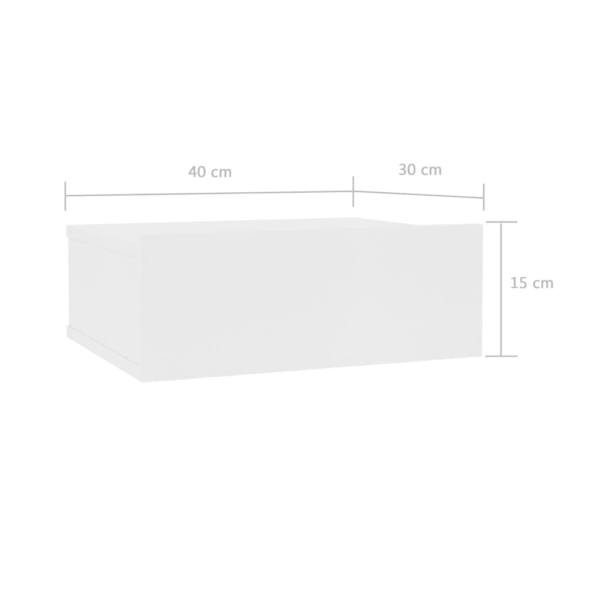

In [12]:
img

In [13]:
forward(ename, img)

NameError: name 'img_url' is not defined

In [ ]:
subset

In [ ]:
output = pd.DataFrame({"index": [], "prediction": []})

In [ ]:
for record in subset:
    img = url_to_image(record["image_link"])
    ename = record["entity_name"]
    
    pred = forward(ename, img)
    
    output.iloc[record["index"], "prediction"] = pred
    
    